In [109]:
using AugmentedGaussianProcesses; const AGP = AugmentedGaussianProcesses
using Statistics, ForwardDiff
using MLDataUtils, CSV, LinearAlgebra, LaTeXStrings, SpecialFunctions
using DrWatson
quickactivate(joinpath(@__DIR__,".."))
include(joinpath(srcdir(),"intro.jl"))

## Parameters and data
nSamples = 100;
nChains = 5;
data = Matrix(CSV.read(joinpath(datadir(),"exp_raw/housing.csv"),header=false))
pointsused = 1:150
y = data[pointsused,1]; y.= y./mean(y)
X = data[pointsused,2:end]; (N,nDim) = size(X)
l = initial_lengthscale(X)

1.7592260566545566

In [110]:
kernel = RBFKernel(l)
K = AugmentedGaussianProcesses.kernelmatrix(X,kernel)+1e-4*I
burnin=1
ν = 10.0; likelihood = StudentTLikelihood(ν); noisegen = TDist(ν); lname="StudentT"
# likelihood = LaplaceLikelihood(); noisegen = Laplace(); lname = "Laplace";
# likelihood = LogisticLikelihood(); noisegen = Normal(); lname = "Logistic"
if lname == "Laplace"
    global b = 1.0
    global C()=1/(2b)
    global g(y) = 0.0
    global α(y) = y^2
    global β(y) = 2*y
    global γ(y) = 1.0
    global φ(r) = exp(-sqrt(r)/b)
    global ∇φ(r) = -exp(-sqrt(r)/b)/(2*b*sqrt(r))
    global ll(y,x) = 1/(2b)*exp(-abs(y-x)/b)
elseif lname == "StudentT"
    global C()= gamma(0.5*(ν+1))/(sqrt(ν*π)*gamma(0.5*ν))
    global g(y) = 0.0
    global α(y) = y^2
    global β(y) = 2*y
    global γ(y) = 1.0
    global φ(r) = (1+r/ν)^(-0.5*(ν+1))
    global ∇φ(r) = -(0.5*(1+ν)/ν)*(1+r/ν)^(-0.5*(ν+1)-1)
    global ll(y,x) = pdf(LocationScale(y,1.0,TDist(ν)),x)
elseif lname == "Logistic"
    global C()= 0.5
    global g(y) = 0.5*y
    global α(y) = 0.0
    global β(y) = 0.0
    global γ(y) = 1.0
    global φ(r) = sech.(0.5*sqrt.(r))
    global ∇φ(r) = -0.25*(sech.(0.5*sqrt.(r))*tanh.(0.5*sqrt.(r)))/(sqrt.(r))
    global ll(y,x) = logistic(y*x)
end
AGP.@augmodel(St,Regression,C,g,α,β, γ, φ, ∇φ)

Statistics.var(::StLikelihood) = ν/(ν-2.0)

AGP.@augmodel(La,Regression,C,g,α,β, γ, φ, ∇φ)

Statistics.var(::LaLikelihood) = 2*b^2

var(StLikelihood())
function AGP.grad_quad(likelihood::LaLikelihood{T},y::Real,μ::Real,σ²::Real,inference::Inference) where {T<:Real}
    nodes = inference.nodes*sqrt2*sqrt(σ²) .+ μ
    Edlogpdf = dot(inference.weights,AGP.grad_log_pdf.(likelihood,y,nodes))
    Ed²logpdf =  zero(T)#1/(b * sqrt(twoπ*σ²))
    return -Edlogpdf::T, Ed²logpdf::T
end
AGP.@augmodel(Lo,Classification,C,g,α,β, γ, φ, ∇φ)

AGP.hessian_log_pdf(::LoLikelihood{T},y::Real,f::Real) where {T<:Real} = -exp(y*f)/AGP.logistic(-y*f)^2

AGP.grad_log_pdf(::LoLikelihood{T},y::Real,f::Real) where {T<:Real} = y*AGP.logistic(-y*f)

##
if lname == "Logistic"
    global genlikelihood = LoLikelihood()
elseif lname == "Laplace"
    global genlikelihood = LaLikelihood()
elseif lname == "StudentT"
    global genlikelihood = StLikelihood()
end


nIter = 50
eta1 = zeros(N,nIter)
eta2 = zeros(N,N,nIter)
function cb(model,iter)
    eta1[:,iter+1] = model.η₁[1]
    eta2[:,:,iter+1] = model.η₂[1]
end

cb (generic function with 1 method)

In [111]:
amodel = VGP(X,y,RBFKernel(0.1),genlikelihood,AnalyticVI(),verbose=3,optimizer=false)
train!(amodel,iterations=nIter,callback=cb)

Starting training Variational Gaussian Process with a Generic Likelihood infered by Analytic Variational Inference  with 150 samples with 13 features and 1 latent GP

Training Progress:   2%|█                               |  ETA: 0:00:33
  iter:  1




Training Progress:  40%|█████████████                   |  ETA: 0:00:01
  iter:  20
4m  ELBO:  -232.09058967064882

Training Progress:  74%|████████████████████████        |  ETA: 0:00:00
  iter:  37
4m  ELBO:  -232.09058967064882

Training Progress: 100%|████████████████████████████████| Time: 0:00:01
  iter:  50
  ELBO:  -232.09058967064882


Training ended after 50 iterations. Total number of iterations 50


true

In [118]:
varω = zeros(N)

function varomega(c)
    ForwardDiff.gradient(x->∇φ(x[1]),[c])[1]/φ(c) - (∇φ(c)/φ(c))^2
end

for (i,r) in enumerate(amodel.likelihood.c²[1])
    varω[i] = varomega(r)
end

diffeta1 = eta1.-amodel.η₁[1];
diffeta2 = eta2.-amodel.η₂[1];
convergence_matrix_eta1 = 2*Diagonal(β(y))*Diagonal(varω)*Diagonal(amodel.μ[1])*amodel.Σ[1];
convergence_matrix_eta2 = zeros(N,N,N);
for i in 1:N, j in 1:N, k in 1:N
    convergence_matrix_eta2[i,j,k] = 2*γ(y[i])*varω[i]*amodel.Σ[1][j,i]*(amodel.Σ[1][i,k]+2*amodel.μ[1][i]*amodel.μ[1][k])
end

In [119]:
eps_0_eta1 = diffeta1[:,1]
eps_tmax_eta1 = zeros(nIter);
eps_tmean_eta1 = zeros(nIter);
eps_0_eta2 = diffeta2[:,:,1]
eps_tmax_eta2 = zeros(nIter);
eps_tmean_eta2 = zeros(nIter);
for i in 1:nIter
    i%10 == 0 ? @info("iteration $i") : nothing
    eps_tmax_eta1[i] = maximum(abs.(eps_0_eta1))
    eps_tmax_eta2[i] = maximum(abs.(eps_0_eta2))
    eps_tmean_eta1[i] = norm(eps_0_eta1)
    eps_tmean_eta2[i] = norm(eps_0_eta2)
    global eps_0_eta1 = convergence_matrix_eta1*eps_0_eta1
    eps_0_eta2_old = copy(eps_0_eta2)
    for j in 1:N, k in 1:N
        eps_0_eta2[j,k] = eps_0_eta2_old[j,k]*sum(convergence_matrix_eta2[:,j,k])
    end
end
# lambda_mu = maximum(eigen(convergence_matrix_eta1).values);

┌ Info: iteration 10
└ @ Main In[119]:8
┌ Info: iteration 20
└ @ Main In[119]:8
┌ Info: iteration 30
└ @ Main In[119]:8
┌ Info: iteration 40
└ @ Main In[119]:8
┌ Info: iteration 50
└ @ Main In[119]:8


In [120]:
maximum(eigen(convergence_matrix_eta1).values)

0.17554741663533244

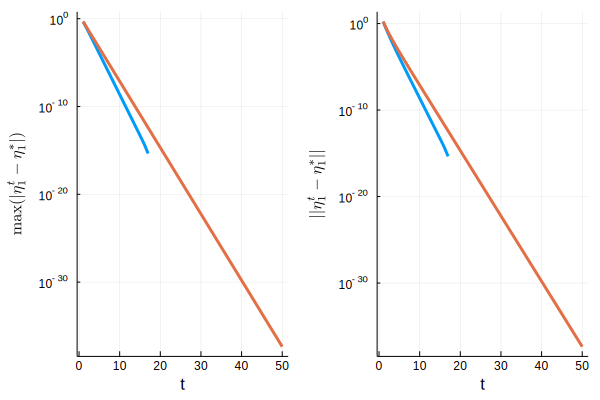

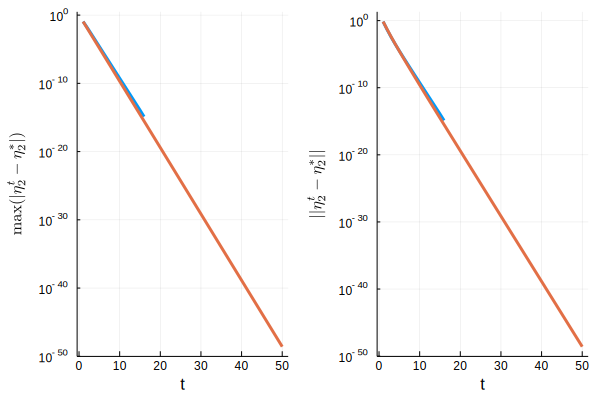

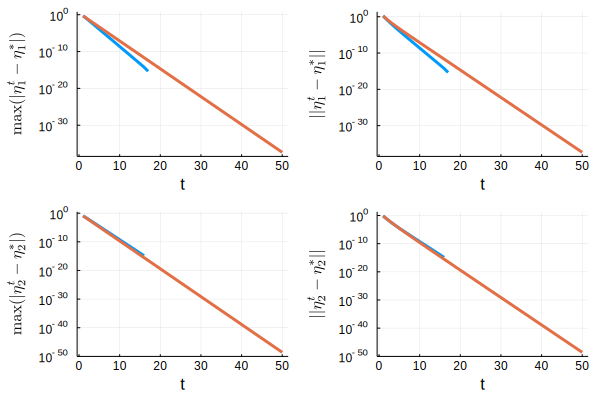

In [122]:
using Plots
##
default(lw=3.0,legend=false)
maxdiffeta1 = maximum.(abs,eachcol(diffeta1))
maxdiffeta1 = maxdiffeta1[maxdiffeta1.!=0]
p1 = plot(1:length(maxdiffeta1),maxdiffeta1,lab="Max Error eta 1",yaxis=:log,xlabel="t",ylabel=L"\max(|\eta_1^t-\eta_1^*|)")
plot!(1:nIter,eps_tmax_eta1,lab="Max Bound")
##
meandiffeta1 = norm.(eachcol(diffeta1))
meandiffeta1 = meandiffeta1[meandiffeta1.!=0]
p2 = plot(1:length(meandiffeta1),meandiffeta1,lab="Mean Error eta 1",yaxis=:log,xlabel="t",ylabel=L"||\eta_1^t-\eta_1^*||")
plot!(1:nIter,eps_tmean_eta1,lab="Mean Bound")

plot(p1,p2) |> display
# plot!(1:nIter,maximum(eachcol(diffmu)),lab="Error sigma")

##

maxdiffeta2 = maximum.(abs,[diffeta2[:,:,i] for i in 1:nIter])
maxdiffeta2 = maxdiffeta2[maxdiffeta2.!=0]
p3 = plot(1:length(maxdiffeta2),maxdiffeta2,lab="Max Error eta 2",yaxis=:log,xlabel="t",ylabel=L"\max(|\eta_2^t-\eta_2^*|)")
plot!(1:nIter,eps_tmax_eta2,lab="Max Bound")

##
meandiffeta2 = norm.([diffeta2[:,:,i] for i in 1:nIter])
meandiffeta2 = meandiffeta2[meandiffeta2.!=0]
p4 = plot(1:length(meandiffeta2),meandiffeta2,lab="Mean Error eta 2",yaxis=:log,xlabel="t",ylabel=L"||\eta_2^t-\eta_2^*||")
plot!(1:nIter,eps_tmean_eta2,lab="Mean Bound")
plot(p3,p4) |> display
plot(p1,p2,p3,p4)


In [16]:
savefig("Convergence.png")